In [ ]:
#!/usr/bin/env python
"""
run_sliceTCA.py
Loads a .mat file with X (N×T×K) and runs sliceTCA:
   X[n,t,k] ≈ ∑ₙᵣ uₙ^{(r)} A_{t,k}^{(r)}
            + ∑ₜᵣ vₜ^{(r)} B_{n,k}^{(r)}
            + ∑ₖʳ wₖ^{(r)} C_{n,t}^{(r)}
(see Pellegrino et al. eq. (4)) :contentReference[oaicite:2]{index=2}&#8203;:contentReference[oaicite:3]{index=3}.
"""

'\nrun_sliceTCA.py\nLoads a .mat file with X (N×T×K) and runs sliceTCA:\n   X[n,t,k] ≈ ∑ₙᵣ uₙ^{(r)} A_{t,k}^{(r)}\n            + ∑ₜᵣ vₜ^{(r)} B_{n,k}^{(r)}\n            + ∑ₖʳ wₖ^{(r)} C_{n,t}^{(r)}\n(see Pellegrino et al. eq. (4)) :contentReference[oaicite:2]{index=2}&#8203;:contentReference[oaicite:3]{index=3}.\n'

In [ ]:
# install the slicetca package
!pip install git+https://github.com/arthur-pe/slicetca.git
# import necessary modules
import torch
import sys
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt

  Cloning https://github.com/arthur-pe/slicetca.git to /tmp/pip-req-build-5vsax0lo
  Running command git clone --filter=blob:none --quiet https://github.com/arthur-pe/slicetca.git /tmp/pip-req-build-5vsax0lo
  Resolved https://github.com/arthur-pe/slicetca.git to commit 61d77c6f8326ab20b2c92f9c9ea7f6e9d9095b36
  Preparing metadata (setup.py) ... done


In [ ]:
import slicetca

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device);

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -V

Python 3.11.12


In [ ]:
input_path = '/content/drive/Othercomputers/Lenovo Laptop/temporal_criticality_of_latent_results/TCA/BLA/tensor_data.mat'

In [ ]:
mat = sio.loadmat(input_path)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'fs', 'post_data', 'pre_data', 'time_vector'])

In [ ]:
# ————————————————
# Load data
# ————————————————
mat = sio.loadmat(input_path)
X = mat['pre_data'].astype(np.float32)     #shape (N, T,K)
# shape (K, N, T)
X = np.transpose(X, (2, 0, 1))
# your_data is a numpy array of shape (trials, neurons, time).
data = torch.tensor(X, dtype=torch.float, device=device)
print(data.shape)

torch.Size([60, 32, 204])


In [ ]:
# ————————————————
# Hyperparameters
# ————————————————
R_neuron = 3    # e.g. start with 2 neuron‐slicing comps
R_trial  = 3    # e.g. 4 trial‐slicing comps
R_time   = 3    # e.g. 1 time‐slicing comp

In [ ]:
# ————————————————
# Initialize and fit model
# ————————————————

components, model = slicetca.decompose(data,
                    (R_neuron,R_time,R_trial),
                    max_iter=5000)

Loss: 0.9960230588912964 : 100%|██████████| 5000/5000 [02:53<00:00, 28.79it/s]


In [ ]:
# For a not positive decomposition, we apply uniqueness constraints
model = slicetca.invariance(model)

The invariance converged. Invariance loss: 4.407458305358887 :   7%|▋         | 717/10000 [00:20<04:31, 34.25it/s]


SliceTCA Decomposition: BLA Condition - Pre-stimulus


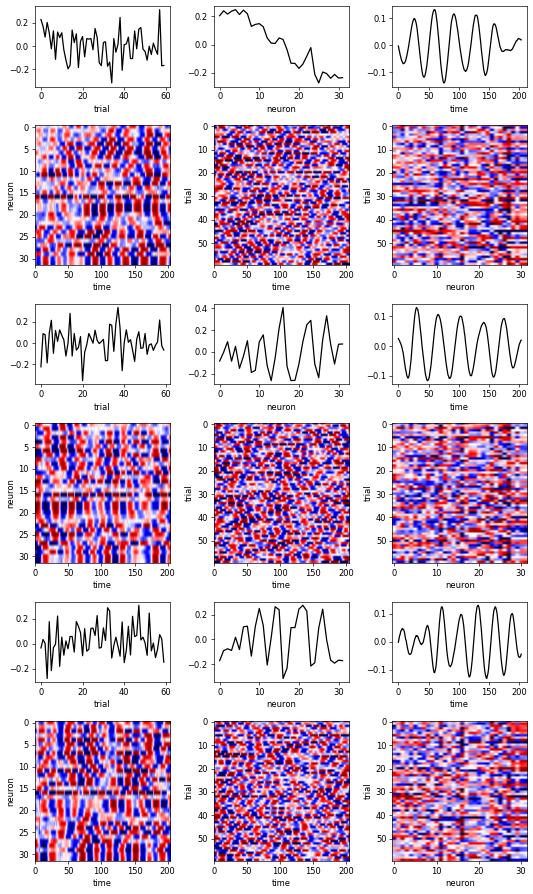

In [ ]:
print("SliceTCA Decomposition: BLA Condition - Pre-stimulus")
slicetca.plot(model)
# plt.suptitle( fontsize=14)
plt.show()

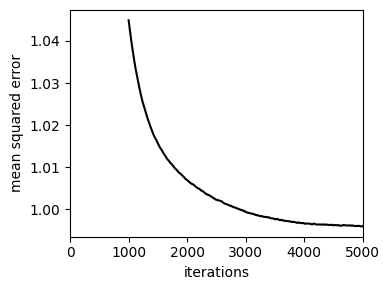

In [ ]:
plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(1000,len(model.losses)), model.losses[1000:], 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model.losses))
plt.tight_layout()

In [ ]:
model

SliceTCA(
  (vectors): ModuleList(
    (0): ParameterList(
        (0): Parameter containing: [torch.float32 of size 3x60]
        (1): Parameter containing: [torch.float32 of size 3x32x204]
    )
    (1): ParameterList(
        (0): Parameter containing: [torch.float32 of size 3x32]
        (1): Parameter containing: [torch.float32 of size 3x60x204]
    )
    (2): ParameterList(
        (0): Parameter containing: [torch.float32 of size 3x204]
        (1): Parameter containing: [torch.float32 of size 3x60x32]
    )
  )
)

In [ ]:
# ————————————————
# Save results
# ————————————————
# sio.savemat(sys.argv[2], {
    'U': U, 'A': A,
    'V': V, 'B': B,
    'W': W, 'C': C,
    'reconstruction': model.reconstruct()
# })
# print("sliceTCA complete. Results saved to", sys.argv[2])

In [ ]:
# ————————————————
# Load data
# ————————————————
X_post = mat['post_data'].astype(np.float32)     #shape (N, T,K)
# shape (K, N, T)
X_post = np.transpose(X_post, (2, 0, 1))
# your_data is a numpy array of shape (trials, neurons, time).
data_post = torch.tensor(X_post, dtype=torch.float, device=device)
print(data_post.shape)

torch.Size([60, 32, 205])


In [ ]:
components_post, model_post = slicetca.decompose(data_post,
                    (R_neuron,R_time,R_trial),
                    max_iter=5000)

Loss: 0.9218460917472839 : 100%|██████████| 5000/5000 [03:08<00:00, 26.47it/s]


In [ ]:
# For a not positive decomposition, we apply uniqueness constraints
model_post = slicetca.invariance(model_post)

The invariance converged. Invariance loss: 3.8559696674346924 :   2%|▏         | 170/10000 [00:04<04:34, 35.85it/s]


SliceTCA Decomposition: BLA Condition - post-stimulus


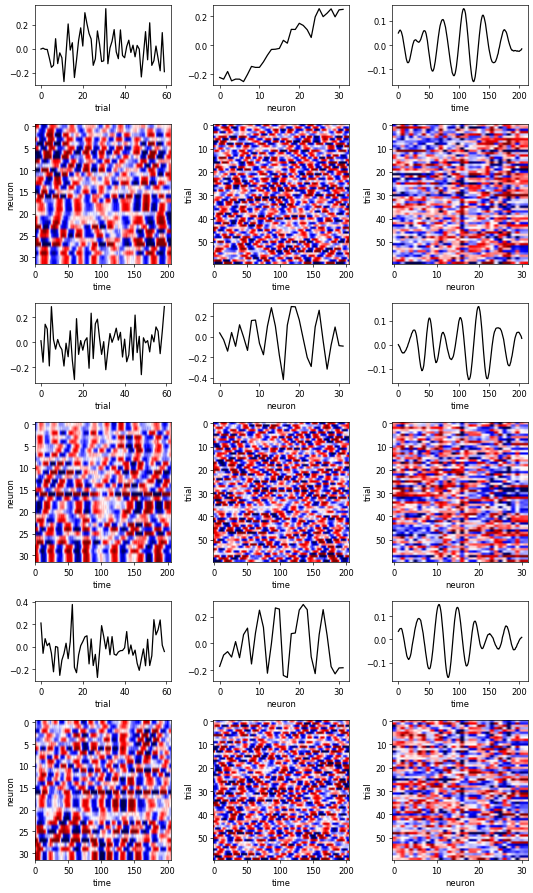

In [ ]:
print("SliceTCA Decomposition: BLA Condition - post-stimulus")
slicetca.plot(model_post)
plt.show()

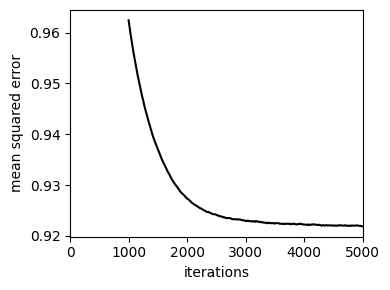

In [ ]:
plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(1000,len(model_post.losses)), model_post.losses[1000:], 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model_post.losses))
plt.tight_layout()